In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [3]:
df = pd.read_csv('../../Data/02_processed/products_prepared.csv')

In [4]:
df.loc[df['id'] == 194970]

,id,product_name,brands,labels,countries,ingredients,allergens_0,allergens_1,allergens_2,traces,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,fruits_vegetables_nuts,nutrition_score,glycemic-index_100g
11060,194970,Banania,Banania,Fabriqué en france,France,Non défini,Non défini,Non défini,Non défini,Non défini,...,11.5,11.0,0.7,4.2,0.04,0.015748,NaN,NaN,18.0,NaN


In [29]:
df['allergens_0'].value_counts() > 100

Non défini                          True
Blé                                 True
Lait                                True
Soja                                True
Gluten                              True
                                   ...  
Noisettes décortiquées*            False
Lait de chèvre                     False
Matière grasse laitière anhydre    False
Pâte                               False
Lactosérum en poudre               False
Name: allergens_0, Length: 531, dtype: bool

## Exploratory Data Analysis

In [5]:
df['brands'] = df['brands'].astype('str')
df['product_name'] = df['product_name'].astype('str')

In [6]:
brands_corpus = ' '.join(df['brands'])
products_corpus = ' '.join(df['product_name'])

In [7]:
# define french stopwords
stops = "alors au aucuns aussi autre avant avec avoir bon car ce cela ces ceux chaque ci comme comment dans des du dedans dehors depuis devrait doit donc dos début elle elles en encore essai est et eu fait faites fois font hors ici il ils je juste la le les leur là ma maintenant mais mes mien moins mon mot même ni nommés notre nous ou où par parce pas peut peu plupart pour pourquoi quand que quel quelle quelles quels qui sa sans ses seulement si sien son sont sous soyez sujet sur ta tandis tellement tels tes ton tous tout trop très tu voient vont votre vous vu ça étaient état étions été être de à aux g mg".split(" ")

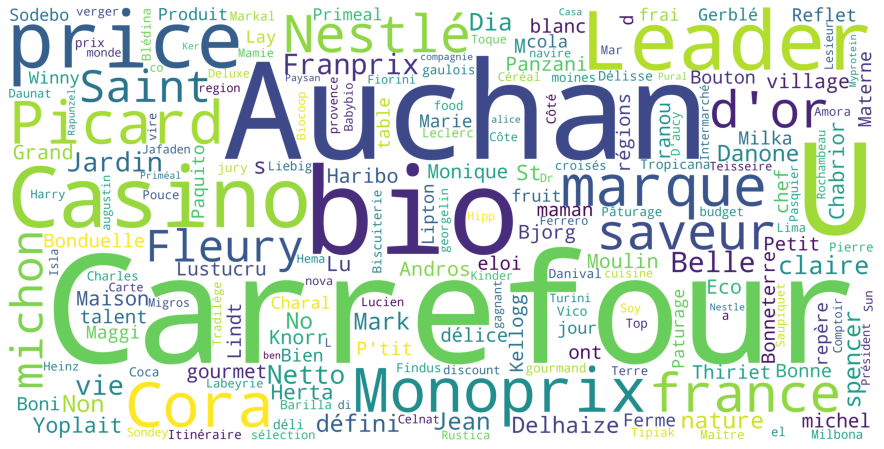

In [8]:
brands_wordcloud = WordCloud(stopwords = stops, background_color = 'white', collocations=False, height = 2000, width = 4000).generate(brands_corpus)
plt.figure(figsize = (16,8))
plt.imshow(brands_wordcloud)
plt.axis('off')
plt.show()

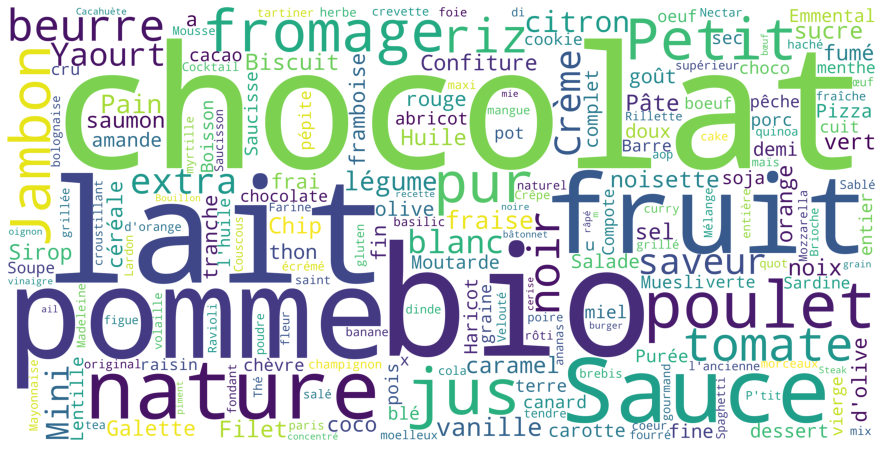

In [9]:
products_wordcloud = WordCloud(stopwords = stops, background_color = 'white', collocations=False, height = 2000, width = 4000).generate(products_corpus)
plt.figure(figsize = (16,8))
plt.imshow(products_wordcloud)
plt.axis('off')
plt.show()

In [10]:
df['content'] = df[['brands', 'product_name']].astype(str).apply(lambda x: ' // '.join(x), axis = 1)

In [11]:
df['content'].fillna('Null', inplace = True)

## Training recommander

In [12]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = stops)
tfidf_matrix = tf.fit_transform(df['content'])

In [13]:
 print(tf.get_feature_names())

gergelim', 'áreaviva', 'áreaviva continente', 'âge', 'âge 12', 'âge 700g', 'âge 800g', 'âge 900g', 'âge biologique', 'âge formule', 'âge lactel', 'âge mois', 'âge oeba', 'âge tranché', 'ägg', 'ägyptisch', 'ägyptischer', 'ägyptischer amun', 'älgar', 'äpple', 'äpple jorgubb', 'ässä', 'ässä vaahtix', 'æble', 'æble figen', 'ærter', 'çamlica', 'çamlica limon', 'çamlica çamlica', 'çasino', 'çasino beurre', 'çikolata', 'çiğ', 'çiğ köfte', 'ècosse', 'èrdnüssen', 'èrdnüssen und', 'éblouissants', 'éblouissants palmiers', 'ébène', 'ébène truffes', 'éc', 'écaillon', 'écaillon briquette', 'écaillon dorée', 'écaillon faisselle', 'échalote', 'échalote allégée', 'échalote amora', 'échalote aneth', 'échalote ciboulette', 'échalote coupée', 'échalote lait', 'échalote persil', 'échalote poisson', 'échalote vin', 'échalotes', 'échalotes allégée', 'échalotes bouteille', 'échalotes chianti', 'échalotes ciboulette', 'échalotes cuites', 'échalotes fines', 'échalotes gratin', 'échalotes écrasée', 'échalotte', 

In [14]:
user_input = input('Quel produit recherchez-vous ?')
input_matrix = tf.transform([user_input])
cosine_similarities = linear_kernel(input_matrix, tfidf_matrix)

In [15]:
results = {}
similar_indices = cosine_similarities[0].argsort()[-10:-1]
similar_items = [(cosine_similarities[0][i], df['id'][i], df['product_name'][i]) for i in similar_indices]

In [16]:
print(similar_items)

[(0.5219177274971508, 198110, 'Salade de fruits au sirop'), (0.565327596064594, 231018, 'Salade de fruits surgelée'), (0.5694423804215442, 241248, 'Salade de fruits'), (0.5813213592112929, 198156, 'Salade de fruits'), (0.5935267512644531, 231001, 'Salade de fruits exotiques'), (0.599508541537888, 231019, 'Salade de fruits pêche'), (0.6021277615431244, 190869, 'Salade de fruits'), (0.6474419455900342, 230512, 'Salade aux fruits rouges'), (0.6564888755677821, 263525, 'Salade de fruits')]


## Sentence transformers

In [17]:
from sentence_transformers import SentenceTransformer, models
from transformers import CamembertModel, CamembertTokenizer

In [18]:
# Spécifie le calcul à mettre en place pour passer du word embedding au sentence embedding
word_embedding_model = models.Transformer('camembert-base')  
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode_mean_tokens=True,                                pooling_mode_max_tokens=False)  
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [19]:
from numpy import genfromtxt
embeddings = genfromtxt('product_matrix.csv', delimiter=',')

In [22]:
embeddings.index([(uid, text, None) for uid, text in enumerate(df)])

print("%-20s %s" % ("Query", "Best Match"))
print("-" * 50)

# Run an embeddings search for each query
for query in (user_input):
    # Extract uid of first result
    # search result format: (uid, score)
    uid = embeddings.search(query, 1)[0][0]

    # Print text
    print("%-20s %s" % (query, data[uid]))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [24]:
import faiss

In [26]:
embeddings.shape

(96544,)

In [27]:
# Step 1: Change data type
embeddings = np.array([embedding for embedding in embeddings]).astype("float32")

# Step 2: Instantiate the index
index = faiss.IndexFlatL2(embeddings.shape)

# Step 3: Pass the index to IndexIDMap
index = faiss.IndexIDMap(index)

# Step 4: Add vectors and their IDs
index.add_with_ids(embeddings, df.id.values)

# Retrieve the 10 nearest neighbours
D, I = index.search(np.array([embeddings[5415]]), k=10)

TypeError: Wrong number or type of arguments for overloaded function 'new_IndexFlatL2'.
  Possible C/C++ prototypes are:
    faiss::IndexFlatL2::IndexFlatL2(faiss::Index::idx_t)
    faiss::IndexFlatL2::IndexFlatL2()
